# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

2.15.0


In [3]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# import pathlib
# from pathlib import Path
# drive.mount('/content/gdrive')
from zipfile import ZipFile
with ZipFile('./Project_data.zip','r') as zip:
  zip.extractall('/tmp')

Mounted at /content/gdrive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_path =  "/tmp/Project_data/train"
val_path =  "/tmp/Project_data/val"
train_doc = np.random.permutation(open('/tmp/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/tmp/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes

In [5]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


#### Utitlity Functions

In [6]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [7]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [8]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = '/tmp/Models/' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

#Conv3D Models

In [11]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

##Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [12]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 60, 60, 16)    0         
 D)                                                              
                                                              

In [13]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [14]:
history_model_conv3D_1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-14-077818d29777>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-9-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
66/67 [============================>.] - ETA: 2s - loss: 1.5873 - categorical_accuracy: 0.4485

<ipython-input-9-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5893 - categorical_accuracy: 0.4465
Epoch 1: val_loss improved from inf to 4.37204, saving model to /content/gdrive/My Drive/Models/model_conv3D_1_2024-04-0211_48_00.086257/model-00001-1.58929-0.44646-4.37204-0.18000.h5
67/67 [==============================] - 170s 2s/step - loss: 1.5893 - categorical_accuracy: 0.4465 - val_loss: 4.3720 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.2117 - categorical_accuracy: 0.5430
Epoch 2: val_loss did not improve from 4.37204
67/67 [==============================] - 157s 2s/step - loss: 1.2117 - categorical_accuracy: 0.5430 - val_loss: 6.5345 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.1136 - categorical_accuracy: 0.5882
Epoch 3: val_loss improved from 4.37204 to 2.24576, saving model to /content/gdrive/My Drive/Models/model_conv3D_1_2024-04-0211_48_00.086257/model-00003-1.11364-0.58824-2.24576-0.37000.h5
67/67 [==============================] - 154s 2s/step - loss: 1.1136 - categorical_accuracy: 0.5882 - val_loss: 2.2458 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 4/25
67/67 [==============================] - ETA: 0s - loss: 1.0521 - categorical_accuracy: 0.5928
Epoch 4: val_loss did not improve from 2.24576
67/67 [==============================] - 145s 2s/step - loss: 1.0521 - catego

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


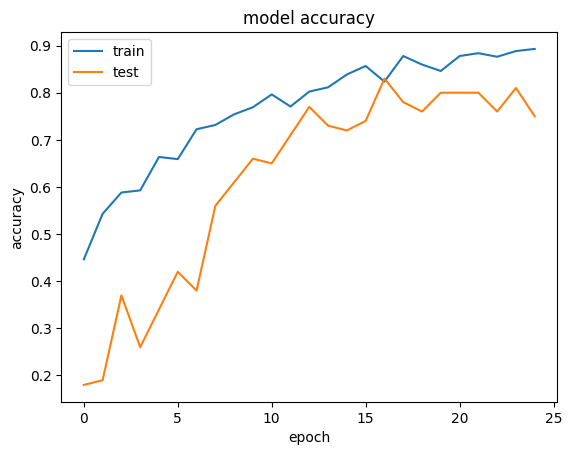

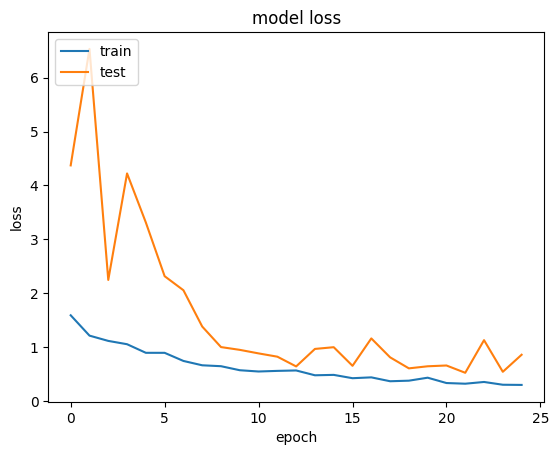

In [15]:
plot_loss_accuracy(history_model_conv3D_1)


##Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [16]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_

In [17]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [18]:
history_model_conv3D_2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-18-5c3dcdbec0a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-9-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
66/67 [============================>.] - ETA: 1s - loss: 1.3917 - categorical_accuracy: 0.4803

<ipython-input-9-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.3993 - categorical_accuracy: 0.4781
Epoch 1: val_loss improved from inf to 2.47138, saving model to /content/gdrive/My Drive/Models/model_conv3D_2_2024-04-0211_48_00.086257/model-00001-1.39929-0.47813-2.47138-0.23000.h5
67/67 [==============================] - 125s 2s/step - loss: 1.3993 - categorical_accuracy: 0.4781 - val_loss: 2.4714 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1565 - categorical_accuracy: 0.5354
Epoch 2: val_loss did not improve from 2.47138
67/67 [==============================] - 112s 2s/step - loss: 1.1565 - categorical_accuracy: 0.5354 - val_loss: 4.0244 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9546 - categorical_accuracy: 0.6471
Epoch 3: val_loss did not improve from 2.47138
67/67 [==============================] - 112s 2s/step - loss: 0.9546 - categorica

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


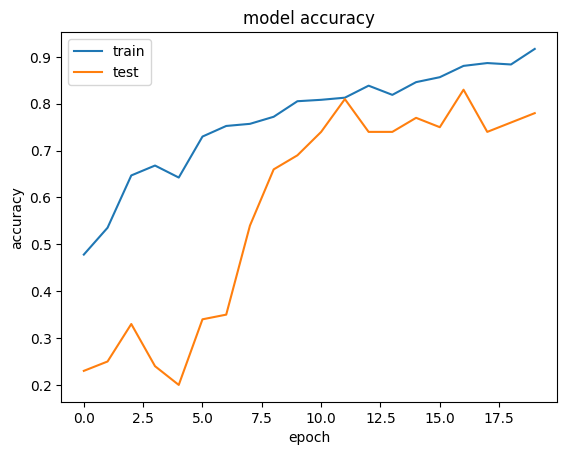

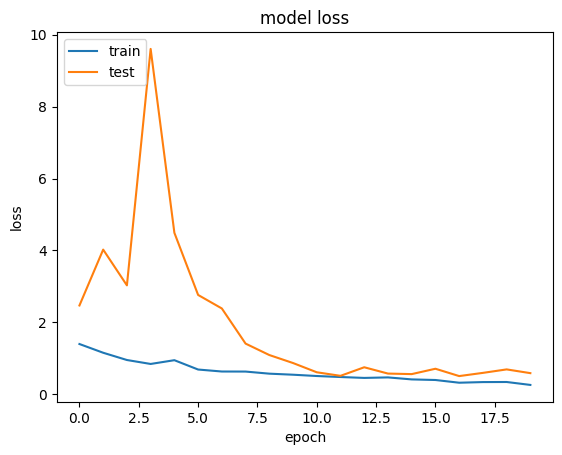

In [19]:
plot_loss_accuracy(history_model_conv3D_2)

##Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [20]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 15, 60, 60, 16)    0         
 g3D)                                                            
                                                            

In [21]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [22]:
history_model_conv3D_3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-22-9ca23891ea93>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-9-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
66/67 [============================>.] - ETA: 2s - loss: 1.7312 - categorical_accuracy: 0.3879

<ipython-input-9-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.7364 - categorical_accuracy: 0.3861
Epoch 1: val_loss improved from inf to 6.41772, saving model to /content/gdrive/My Drive/Models/model_conv3D_3_2024-04-0211_48_00.086257/model-00001-1.73640-0.38612-6.41772-0.20000.h5
67/67 [==============================] - 195s 3s/step - loss: 1.7364 - categorical_accuracy: 0.3861 - val_loss: 6.4177 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2962 - categorical_accuracy: 0.5113
Epoch 2: val_loss improved from 6.41772 to 5.52293, saving model to /content/gdrive/My Drive/Models/model_conv3D_3_2024-04-0211_48_00.086257/model-00002-1.29623-0.51131-5.52293-0.24000.h5
67/67 [==============================] - 185s 3s/step - loss: 1.2962 - categorical_accuracy: 0.5113 - val_loss: 5.5229 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.1738 - categorical_accu

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


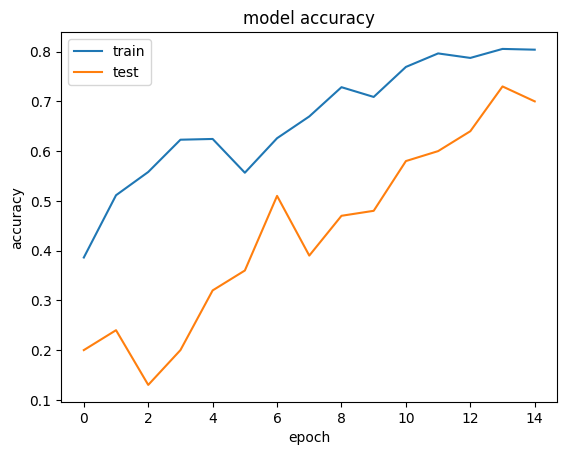

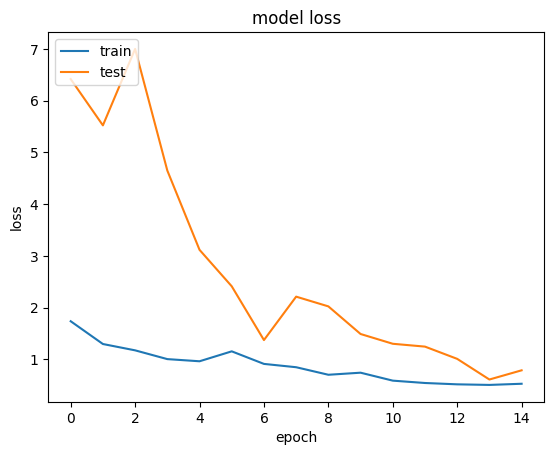

In [23]:
plot_loss_accuracy(history_model_conv3D_3)

##Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [24]:
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [25]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16   6016      
                             )                                   
                                                                 
 activation_21 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                            

In [26]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
history_model_conv3D_4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-27-fe0eb2a284f3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-9-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
65/67 [============================>.] - ETA: 3s - loss: 1.7224 - categorical_accuracy: 0.4092

<ipython-input-9-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.7202 - categorical_accuracy: 0.4057
Epoch 1: val_loss improved from inf to 3.62985, saving model to /content/gdrive/My Drive/Models/model_conv3D_4_2024-04-0211_48_00.086257/model-00001-1.72024-0.40573-3.62985-0.20000.h5
67/67 [==============================] - 162s 2s/step - loss: 1.7202 - categorical_accuracy: 0.4057 - val_loss: 3.6298 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.1896 - categorical_accuracy: 0.5445
Epoch 2: val_loss improved from 3.62985 to 2.01335, saving model to /content/gdrive/My Drive/Models/model_conv3D_4_2024-04-0211_48_00.086257/model-00002-1.18957-0.54449-2.01335-0.37000.h5
67/67 [==============================] - 155s 2s/step - loss: 1.1896 - categorical_accuracy: 0.5445 - val_loss: 2.0134 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.1044 - categorical_accu

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


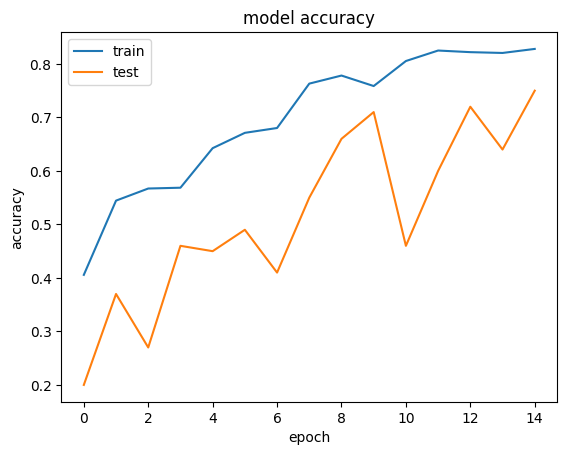

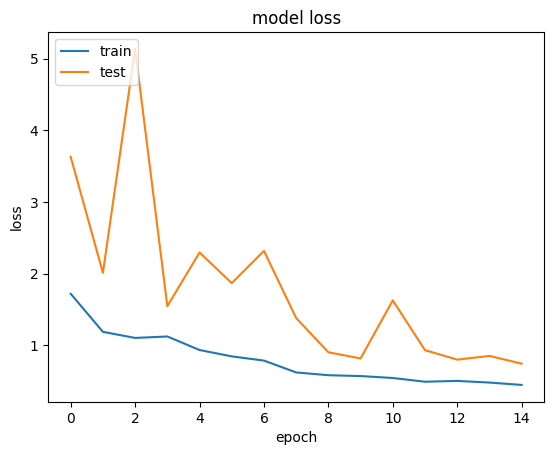

In [28]:
plot_loss_accuracy(history_model_conv3D_4)

#TRANSFER LEARNING - MobileNet Conv2d + GRU

In [29]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

##Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [30]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
17225924/17225924 [==============================] - 2s 0us/step
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 1024)          0         
 stri

In [31]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [32]:
history_model_retrain_mobilenet_gru = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-32-fae4ced237f5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_retrain_mobilenet_gru = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-9-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 2s - loss: 1.2658 - categorical_accuracy: 0.4954

<ipython-input-9-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2520 - categorical_accuracy: 0.4992
Epoch 1: val_loss improved from inf to 1.07115, saving model to /content/gdrive/My Drive/Models/model_retrain_mobilenet_gru_2024-04-0211_48_00.086257/model-00001-1.25200-0.49925-1.07115-0.59000.h5
67/67 [==============================] - 123s 2s/step - loss: 1.2520 - categorical_accuracy: 0.4992 - val_loss: 1.0712 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6570 - categorical_accuracy: 0.7557
Epoch 2: val_loss improved from 1.07115 to 0.72362, saving model to /content/gdrive/My Drive/Models/model_retrain_mobilenet_gru_2024-04-0211_48_00.086257/model-00002-0.65695-0.75566-0.72362-0.67000.h5
67/67 [==============================] - 105s 2s/step - loss: 0.6570 - categorical_accuracy: 0.7557 - val_loss: 0.7236 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


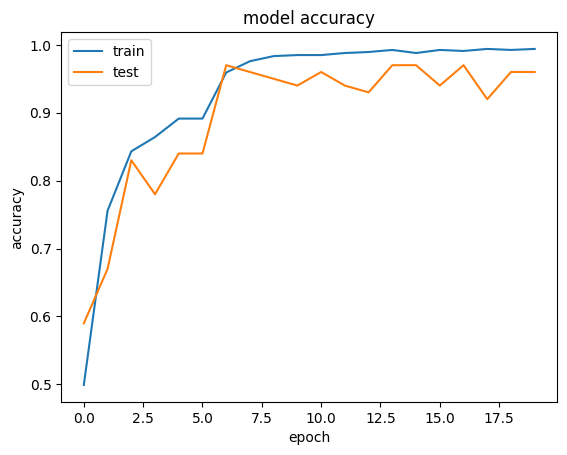

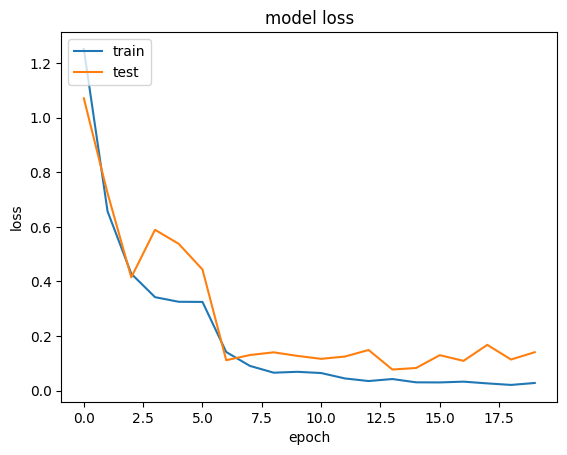

In [33]:
plot_loss_accuracy(history_model_retrain_mobilenet_gru)

##Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [34]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 20, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
    

In [35]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [36]:
history_model_retrain_mobilenet_lstm = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-36-362956b7ebad>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_retrain_mobilenet_lstm = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-9-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 2s - loss: 1.2997 - categorical_accuracy: 0.4523

<ipython-input-9-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2925 - categorical_accuracy: 0.4570
Epoch 1: val_loss improved from inf to 1.03878, saving model to /content/gdrive/My Drive/Models/model_retrain_mobilenet_lstm_2024-04-0211_48_00.086257/model-00001-1.29248-0.45701-1.03878-0.57000.h5
67/67 [==============================] - 117s 2s/step - loss: 1.2925 - categorical_accuracy: 0.4570 - val_loss: 1.0388 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.8198 - categorical_accuracy: 0.6953
Epoch 2: val_loss improved from 1.03878 to 0.64732, saving model to /content/gdrive/My Drive/Models/model_retrain_mobilenet_lstm_2024-04-0211_48_00.086257/model-00002-0.81977-0.69532-0.64732-0.75000.h5
67/67 [==============================] - 102s 2s/step - loss: 0.8198 - categorical_accuracy: 0.6953 - val_loss: 0.6473 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - los

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


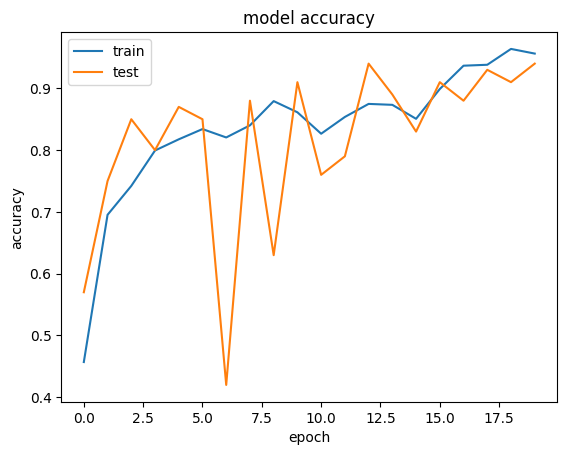

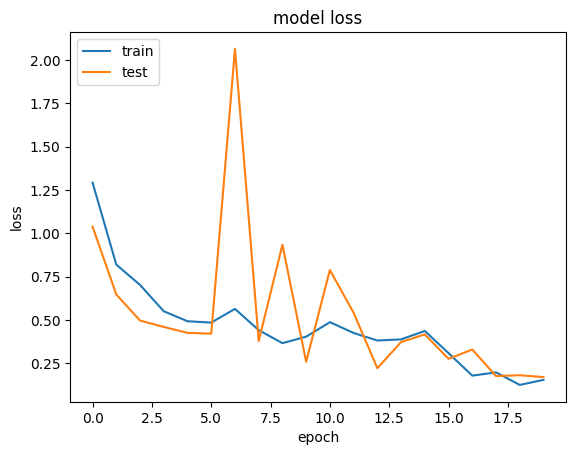

In [37]:
plot_loss_accuracy(history_model_retrain_mobilenet_lstm)